## Ergotropy

The goal of this notebook is to compute the ergotropy $W$ of a system $S$, given an arbitrary initial state and hamiltonian $H$. The ergotropy $W$ is none other that the maximum amount of work extractable from a finite system, and it is given by

$$
W = E(\rho_0) - E(\rho(\tau)) = tr[\rho_0 H] - tr[\rho(\tau) H] = \sum_{j,k}r_j\epsilon_k(|\langle r_j|\epsilon_k \rangle|^2-\delta_{jk})
$$

where we wrote 

$$
\rho_0 = \sum_{j \geqslant 1}r_j|r_j\rangle \langle r_j| \\
H = \sum_{k \geqslant 1}\epsilon_k|\epsilon_k\rangle \langle \epsilon_k| \\
\rho(\tau) = \sum_{j}r_j|\epsilon_j\rangle \langle \epsilon_j|
$$ 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm, lindblad_dissipator)

%matplotlib inline

In [43]:
def energy(_state, _H):
    # Calculate eigenvalues and eigenstates
    _state_eigens = _state.eigenstates()
    _H_eigens = _H.eigenstates()
    
    _energy = 0
    for j in range(len(_state_eigens[0])):
        for k in range(len(_H_eigens[0])):
            _energy += _state_eigens[0][j] * _H_eigens[0][k] * abs(_H_eigens[1][k].overlap(_state_eigens[1][j]))**2
    return _energy

In [3]:
def kronecker_delta(a,b):
    if a==b: return 1
    else: return 0

In [44]:
def ergotropy(_init_state, _H):
    # for now I assume that init_state is given as a density matrix
    # TODO: add a check to enforce this!
    
    # Calculate eigenvalues and eigenstates
    _init_state_eigens = _init_state.eigenstates()
    _H_eigens = _H.eigenstates()
    
    # Next, I have to order the eigenvalues, decreasing for init_state and ascending for H
    _init_state_eigenvalues_ordered = -np.sort(-_init_state_eigens[0], kind='mergesort') # TODO: do this in a better way
    _H_eigenenergies_ordered = np.sort(_H_eigens[0], kind='mergesort')
    
    _ergotropy = 0
    for j in range(len(_init_state_eigenvalues_ordered)):
        for k in range(len(_H_eigenenergies_ordered)):
            _ergotropy += _init_state_eigenvalues_ordered[j]*_H_eigenenergies_ordered[k] * (
                          abs(_H_eigens[1][k].overlap(_init_state_eigens[1][j]))**2-kronecker_delta(j,k))
    return _ergotropy

In [9]:
state = coherent_dm(N=2, alpha=1.0)
state

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.29192658 0.45464871]
 [0.45464871 0.70807342]]

In [31]:
len(state.eigenenergies())

2

In [14]:
-np.sort(-state.eigenenergies(), kind='mergesort')

array([1., 0.])

In [20]:
state.eigenstates()[1]

array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
       Qobj data =
       [[-0.84147098]
        [ 0.54030231]]                                              ,
       Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
       Qobj data =
       [[0.54030231]
        [0.84147098]]                                               ],
      dtype=object)

In [8]:
H = 1.0 * sigmaz() + 0.1 * sigmay()
H

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.+0.j   0.-0.1j]
 [ 0.+0.1j -1.+0.j ]]

In [15]:
np.sort(H.eigenenergies(), kind='mergesort')

array([-1.00498756,  1.00498756])

In [29]:
abs(H.eigenstates()[1][0].overlap(state.eigenstates()[1][0]))**2

0.29295921052367796

In [44]:
ergotropy(coherent_dm(N=2, alpha=1.0),H)

1.4211343986592313

## Master equations solutions
In the following we compare our numerical solutions (obtained via `mesolve`) with the analytical solutions of the article. First we consider the state of the battery and of the charger as harmonic oscillators, and then as qubits. 
We are going to compare the plots of the mean energy $E_B(\tau)$ and of the ergotropy $\epsilon_B(\tau)$, defined as:

$$
E_B(\tau) \equiv tr[H_B \rho_B(\tau)] \\
\epsilon_B(\tau) \equiv tr[H_B \rho_B(\tau)] - \min_{U_B} tr[H_B U_B \rho_B(\tau) U_B\dagger ]
$$

In [5]:
# Define some constants
w_zero = 1.0

In [30]:
# hamiltonian of B
H_B = w_zero * create(5) * destroy(5)

In [27]:
# First case, two harmonic oscillators
a = tensor(destroy(5), qeye(5))
b = tensor(qeye(5), destroy(5))

#H_A = w_zero * a.dag() * a
#H_B = w_zero * b.dag() * b

def delta_HA_t0(_F):
    return _F * ( a.dag() + a)

def H_AB(_g):
    return g * (a * b.dag() + a.dag() * b)

def D_A(_N_B, _gamma):
    return _gamma * (_N_B + 1) * lindblad_dissipator(a)

def D_AD(_N_B, _gamma):
    return _gamma * _N_B * lindblad_dissipator(a.dag())

# at t = 0, A and B do not interact, and they are respectvaly in their ground state
rho0 = tensor(fock_dm(5,0), fock_dm(5,0))

# times to resolve the me at
tlist = np.linspace(0, 100, 200)

In [45]:
F = 0.1 * w_zero
g = 0.2 * w_zero
N_B = 1.0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, tlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_both = [ energy(rho_B[i], H_B) for i in range(len(rho_B)) ]
ergotropy_B_both = [ ergotropy(rho_B[i], H_B) for i in range(len(rho_B)) ]

In [46]:
F = 0
g = 0.2 * w_zero
N_B = 1.0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, tlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_only_T = [ energy(rho_B[i], H_B) for i in range(len(rho_B)) ]
ergotropy_B_only_T = [ ergotropy(rho_B[i], H_B) for i in range(len(rho_B)) ]

In [47]:
F = 0.1 * w_zero
g = 0.2 * w_zero
N_B = 0. # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, tlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_only_F = [ energy(rho_B[i], H_B) for i in range(len(rho_B)) ]
ergotropy_B_only_F = [ ergotropy(rho_B[i], H_B) for i in range(len(rho_B)) ]

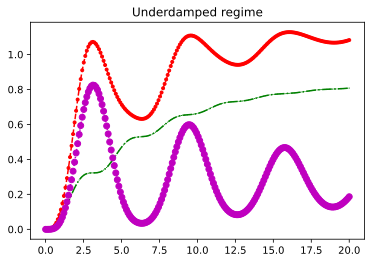

In [62]:
plt.plot(g * tlist, E_B_numeric_both, '.--r', g * tlist, E_B_numeric_only_T, ',-.g', g * tlist, E_B_numeric_only_F, 'o:m')
#plt.plot(g * tlist, E_B_numeric_both, '.--r', g * tlist, E_B_numeric_only_T, ',-.g', g * tlist, E_B_numeric_only_F, 'o:m',
#        g * tlist, ergotropy_B_only_F, '-b')
plt.title("Underdamped regime")
plt.show()

In [55]:
F = 0.1 * w_zero
g = 0.2 * w_zero
N_B = 1.0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, tlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_both_overdamped = [ energy(rho_B[i], H_B) for i in range(len(rho_B)) ]
ergotropy_B_both_overdamped = [ ergotropy(rho_B[i], H_B) for i in range(len(rho_B)) ]

In [56]:
F = 0
g = 0.2 * w_zero
N_B = 1.0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, tlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_only_T_overdamped = [ energy(rho_B[i], H_B) for i in range(len(rho_B)) ]
ergotropy_B_only_T_overdamped = [ ergotropy(rho_B[i], H_B) for i in range(len(rho_B)) ]

In [57]:
F = 0.1 * w_zero
g = 0.2 * w_zero
N_B = 0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = w_zero

# now, I use mesolve to solve the master equation
result = mesolve(H_AB(g) + delta_HA_t0(F), rho0, tlist, [D_A(N_B, gamma), D_AD(N_B, gamma)])

# to calculate E_B and epsilon_B we need rho_B, which is the partial trace of the last state
rho_B = [ result.states[i].ptrace(1) for i in range(len(result.states)) ]

# calculate the energy and ergotropy of rho_B
E_B_numeric_only_F_overdamped = [ energy(rho_B[i], H_B) for i in range(len(rho_B)) ]
ergotropy_B_only_F_overdamped = [ ergotropy(rho_B[i], H_B) for i in range(len(rho_B)) ]

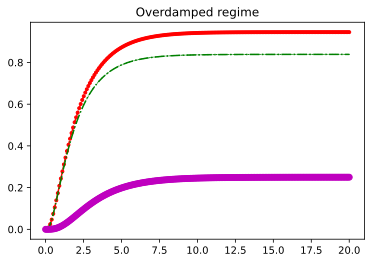

In [60]:
plt.plot(g * tlist, E_B_numeric_both_overdamped, '.--r', g * tlist, E_B_numeric_only_T_overdamped, ',-.g', 
         g * tlist, E_B_numeric_only_F_overdamped, 'o:m')
#plt.plot(g * tlist, E_B_numeric_both, '.--r', g * tlist, E_B_numeric_only_T, ',-.g', g * tlist, E_B_numeric_only_F, 'o:m',
#        g * tlist, ergotropy_B_both, '-b')
plt.title("Overdamped regime")
plt.show()

In [65]:
def E_B_theory_only_T(_w_zero, _gamma, _g, _N_B, _t):
    eps = np.sqrt(_gamma**2 - (4*_g)**2)
    return _w_zero*_N_B*( 1 + (np.exp(-0.5+_gamma*_t)/(eps**2))*(16*_g**2-_gamma*eps*np.sinh(eps*_t/2)
                                                                 -_gamma**2*np.cosh(eps*_t/2)) )
def E_B_theory_only_F(_w_zero, _gamma, _g, _F, _t):
    eps = np.sqrt(_gamma**2 - (4*_g)**2)
    return (w_zero*_F**2/_g**2) * (1 - np.exp(-_gamma*_t/4)*( np.cosh(eps*_t/4) + 
                                                             (_gamma/eps) * np.sinh(eps*_t/4) ) )**2

In [68]:
F = 0.1 * w_zero
g = 0.2 * w_zero
gamma = 0.05 * w_zero
N_B = 1.0
E_B_theory_both = [ E_B_theory_only_F(w_zero,gamma,g,F,t) + E_B_theory_only_T(w_zero,gamma,g,N_B,t)
                   for t in tlist]

/tmp/ipykernel_14094/3155567183.py:6: RuntimeWarning: invalid value encountered in sqrt
  eps = np.sqrt(_gamma**2 - (4*_g)**2)
/tmp/ipykernel_14094/3155567183.py:2: RuntimeWarning: invalid value encountered in sqrt
  eps = np.sqrt(_gamma**2 - (4*_g)**2)


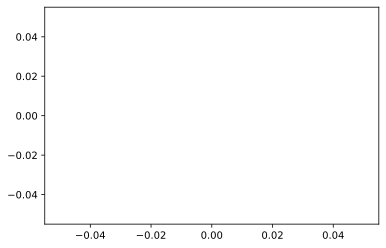

In [71]:
plt.plot(g*tlist, E_B_theory_both, '-k')
plt.show()